In [65]:
import math

import numpy as np
import matplotlib.pyplot as plt

import gen_mandelbrot as gm
import area as a
import sampling_alg as sa

### CDF Divergence

In [66]:
from collections import Counter
plt.figure()
plt.close('all')
plt.rcParams["font.size"] = 18

In [67]:
re_min, re_max = -2, 0.47,
im_min, im_max = -1.12, 1.12
s = 10 ** 6 # sample size
i = 10**4   # iterations
N = 10
rng = np.random.default_rng(0)

In [68]:
samples = sa.sample_pr(re_min,re_max,im_min,im_max,rng,s,rng)
res =gm.mandelbrot(samples, i)
all_divergent = res[res<max(res)]
all_divergent.sort()

# accuracy of cutting off after 4000
percentile = (len(all_divergent[all_divergent<4000])/len(all_divergent))
# point at which 99.99% diverge
nr_iterations = (all_divergent[int(len(all_divergent)*percentile)])

print(f"After {nr_iterations} iterations, approximately {round(percentile,4)*100} percent of the samples in the Mandelbrot set have diverged.")

After 4011 iterations, approximately 99.99 percent of the samples in the Mandelbrot set have diverged.


Of the points that will diverge (that are in the mandelbrot set), CDF of when they diverge.


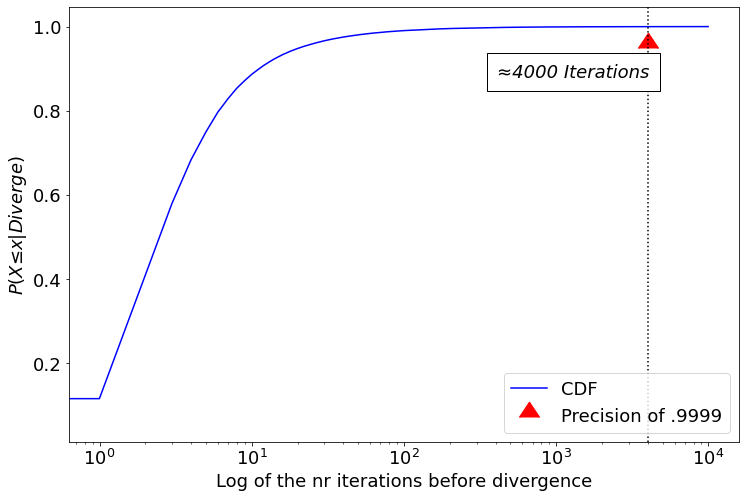

In [69]:
data = all_divergent
count, bins = np.histogram(data,bins=10_000)
pdf = count/ sum(count)
cdf = np.cumsum(count)/len(all_divergent)
print("Of the points that will diverge (that are in the mandelbrot set), CDF of when they diverge.")
plt.figure(figsize=(12,8))
plt.semilogx(bins[:-1], cdf, label="CDF", color='blue')
plt.axvline(nr_iterations,color='black',linestyle=':')

plt.scatter(nr_iterations, percentile-0.05, color='red', marker=10, label='Precision of .9999', s=400,alpha=1)
plt.text(nr_iterations-3600, percentile-0.12, fr'≈4000 Iterations', style='italic',
        bbox={'facecolor':'white','edgecolor': 'black', 'alpha': 1, 'pad': 10})
plt.ylabel(fr"$P(X ≤ x|Diverge)$")
plt.xlabel("Log of the nr iterations before divergence")
plt.legend(loc='lower right')

plt.savefig('figures/'+"cdf_divergence"+'.svg', bbox_inches="tight")

### Scattergrid

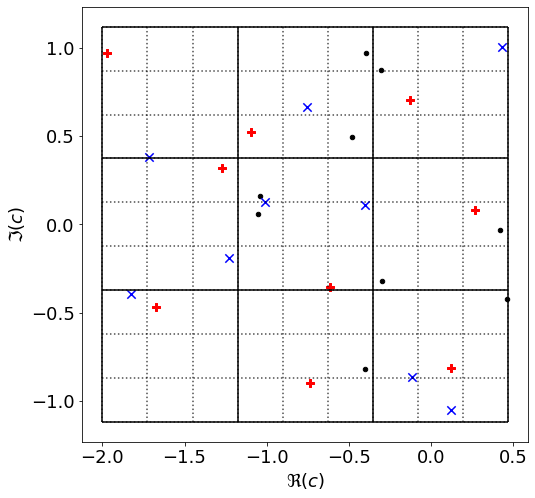

In [70]:
####
# Sampling point grid/ overview. Shows that lhs and ot work.
####

re_min, re_max = -2, 0.47,
im_min, im_max = -1.12, 1.12
s = 10 ** 5 # sample size
i = 10**4   # iterations
N = 10
rng = np.random.default_rng(0)
rng2 = np.random.default_rng(2)
n_samples = 9


lh_sample = sa.sample_lh(re_min, re_max, im_min, im_max,rng, n_samples,rng)
pr_sample = sa.sample_pr(re_min, re_max, im_min, im_max,rng,n_samples,rng)
ot_sample = sa.sample_ot(re_min,re_max,im_min,im_max,rng, n_samples=n_samples,rng_2=rng2,antithetic=False)


plt.figure(figsize=(8,8))
for i in range(n_samples+1):
    plt.vlines(np.linspace(re_min, re_max, n_samples+1)[i],color='black',linestyle=":",alpha=0.7, ymin=im_min, ymax=im_max,)
    plt.hlines(np.linspace(im_min, im_max, n_samples+1)[i],color='black',linestyle=":",alpha=0.7, xmin=re_min, xmax=re_max)

for i in range(math.isqrt(n_samples)+1):
    plt.hlines(np.linspace(im_min, im_max, math.isqrt(n_samples)+1)[i], xmin=re_min, xmax=re_max,color='black')
    plt.vlines(np.linspace(re_min, re_max, math.isqrt(n_samples)+1)[i], ymin=im_min, ymax=im_max,color='black')

plt.scatter(pr_sample.real,pr_sample.imag,color = 'black',s=20,marker="o",label="Pure Random")
plt.scatter(lh_sample.real,lh_sample.imag,color = 'blue',s=70,marker="x",label="Latin Hypercube")
plt.scatter(ot_sample.real,ot_sample.imag,color = 'red',s=70,marker="P",label="Orthogonal")

plt.ylabel("$\Im(c)$")
plt.xlabel("$\Re(c)$")
plt.savefig('figures/'+"scattergrid"+'.svg', bbox_inches="tight")

# Comparison Plot & Table

In [71]:
re_min, re_max = -2, 0.47,
im_min, im_max = -1.12, 1.12
bounds = re_min,re_max, im_min,im_max
rng = np.random.default_rng(0)
rng2 = np.random.default_rng(1)

n_samples = 2**10
iterations = 1000
n_simulations = 1000

def compare_antithetic_area(n_simulations,n_samples,iterations,bounds,funcs=[sa.sample_pr,sa.sample_lh,sa.sample_ot]):
    """
    Generate area values for all sampling methods and their antithetic complements for later comparison.
    Note, here a single quantity of samples and iterations is expected, not an array.
    :param n_simulations: Nr of simulations
    :param n_samples: Nr of samples
    :param iterations: Nr of iterations
    :param bounds: real min, real max, imaginary min, imaginary max
    :param funcs: three sampling function to test
    :return: 2-tuple of np arrays of shape (n_simulations, 3) each: areas_normal, areas_anti
    """


    areas_anti = np.empty((n_simulations,3)) # simulation, sampling method
    areas_normal = np.empty((n_simulations,3))
    re_min, re_max, im_min, im_max = bounds
    for func_idx, samping_func in enumerate(funcs):
        for i in range(n_simulations):
            # run simulation normal
            arr_samples = samping_func(re_min, re_max, im_min, im_max, rng, n_samples, rng2, antithetic=False)
            area_1 = a.calculate_area(samping_func, bounds, s =n_samples, i=iterations,seed1=n_simulations,seed2=n_simulations+1,arr_samples=arr_samples,antithetic=False)
            # run simulation inverted
            arr_samples_anti = sa.convert_antithetic(arr_samples)
            area_2 = a.calculate_area(samping_func, bounds, s=n_samples, i=iterations,seed1=n_simulations*2,seed2=n_simulations*2+1,arr_samples=arr_samples_anti,antithetic=True)
            # take average area
            areas_anti[i,func_idx] = (area_1 + area_2)/2 # change 1 to sampling method
            areas_normal[i,func_idx] = area_1 # change 1 to sampling method
        print(f'{func_idx+1}/3 Sampling methods is done.')
    return areas_normal,areas_anti


areas_normal,areas_anti = compare_antithetic_area(n_simulations,n_samples,iterations,bounds,funcs=[sa.sample_pr,sa.sample_lh,sa.sample_ot])

1/3 Sampling methods is done.
2/3 Sampling methods is done.
3/3 Sampling methods is done.


In [72]:

from scipy.stats import bootstrap,ttest_ind
# T-test on differences in Variances between each method and its antithetic complement.
def bootstrapped_t_test(normal,antithetic_variate,seed,n_resamples,statistic=np.var):
    """
    Compute bootstrapped t-test for any statistic/parameter between a sampling method and its antithetic complement.
    Or generally two numpy arrays.
    :param normal: area values from the non-antithetic sampling method
    :param antithetic_variate:  area values from the antithetic sampling method
    :param seed: random state for bootstrapping
    :param n_resamples: number of resamples; size of sample is len(values)
    :param statistic: parameter to test: e.g., np.mean, np.var, np.std...
    :return: independent ttest results
    """
    rng = np.random.default_rng(seed)
    boot_areas_normal = rng.choice(normal,size = len(normal)*n_resamples, replace=True).reshape((len(normal),n_resamples))
    boot_variances_normal = statistic(boot_areas_normal,axis=0)

    boot_areas_anti = rng.choice(antithetic_variate,size = len(antithetic_variate)*n_resamples, replace=True).reshape((len(antithetic_variate),n_resamples))
    boot_variances_anti = statistic(boot_areas_anti,axis=0)


    return ttest_ind(boot_variances_normal,boot_variances_anti)

In [73]:


n_resamples = 1000
# bootstrapped CI's for the Variance of the area for each method
boot_ci_normal = bootstrap((areas_normal,),np.var,axis=0,confidence_level=0.95,n_resamples=n_resamples,random_state=0)
boot_ci_anti = bootstrap((areas_anti,),np.var,axis=0,confidence_level=0.95,n_resamples=n_resamples,random_state=0)

# Data for table
# Variance for Bar chart
norm_var = np.var(areas_normal,axis=0)
norm_ste = boot_ci_normal.standard_error
norm_ci = boot_ci_normal.confidence_interval

anti_var = np.var(areas_anti,axis=0)
anti_ste = boot_ci_anti.standard_error
anti_ci =  boot_ci_anti.confidence_interval

In [74]:
#test varance of area
ttest_pr_anti = bootstrapped_t_test(areas_normal[:,0],areas_anti[:,0],seed=0,n_resamples=n_resamples,statistic=np.var)
ttest_lh_anti =bootstrapped_t_test(areas_normal[:,1],areas_anti[:,1],seed=0,n_resamples=n_resamples,statistic=np.var)
ttest_ot_anti =bootstrapped_t_test(areas_normal[:,2],areas_anti[:,2],seed=0,n_resamples=n_resamples,statistic=np.var)

ttest_pr_lh = bootstrapped_t_test(areas_normal[:,0],areas_normal[:,1],seed=0,n_resamples=n_resamples,statistic=np.var)
ttest_lh_ot = bootstrapped_t_test(areas_normal[:,1],areas_anti[:,2],seed=0,n_resamples=n_resamples,statistic=np.var)

In [75]:


# Table data
print("Table Data (A indicates antithetic sampling)")
print(f"Variances are: \n "
      f"PRS {round(norm_var[0],3)}\t"
      f"LHS {round(norm_var[1],3)}\t"
      f"OT {round(norm_var[2],3)}\n"
      f"A-PRS {round(anti_var[0],3)}\t"
      f"A-LHS {round(anti_var[1],3)}\t"
      f"A-OT {round(anti_var[2],3)}\n")
print(f"Standard Errors are: \n"
      f"PRS {round(norm_ste[0],3)} \t"
      f"LHS {round(norm_ste[1],3)} \t"
      f"OT {round(norm_ste[2],3)} \n "
      f"A-PRS {round(anti_ste[0],3)} \t"
      f"A-LHS {round(anti_ste[1],3)} \t"
      f"A-OT {round(anti_ste[2],3)}\n")
print(f"Bootstrapped CI's are: \n"
      f"PRS {round(norm_ci.low[0],3)},{round(norm_ci.high[0],3)} \t"
      f"LHS {round(norm_ci.low[1],3)},{round(norm_ci.high[1],3)} \t"
      f"OT {round(norm_ci.low[2],3)},{round(norm_ci.high[2],3)} \n"
      f"A-PRS {round(anti_ci.low[0],3)},{round(anti_ci.high[0],3)} \t"
      f"A-LHS {round(anti_ci.low[1],3)},{round(anti_ci.high[1],3)} \t"
      f"A-OT {round(anti_ci.low[2],3)},{round(anti_ci.high[2],3)} \n")
print(f"Delta Var(X)s are: \n"
      f"PRS {round(norm_var[0] - anti_var[0],3)}\t"
      f"LHS {round(norm_var[1] - anti_var[1],3)}\t"
      f"OT {round(norm_var[2] - anti_var[2],3)}\n")
print(f"T-test results for antithetic implementations are: \n"
      f"PRS {ttest_pr_anti} \n"
      f"LHS {ttest_lh_anti} \n"
      f"OT {ttest_ot_anti} \n")
print(f"Pairwise t-test results pr-lh,lh-ot are: \n"
      f"PRS {ttest_pr_lh} \n"
      f"LHS {ttest_lh_ot} \n")

Table Data (A indicates antithetic sampling)
Variances are: 
 PRS 0.006	LHS 0.003	OT 0.0
A-PRS 0.003	A-LHS 0.001	A-OT 0.0

Standard Errors are: 
PRS 0.0 	LHS 0.0 	OT 0.0 
 A-PRS 0.0 	A-LHS 0.0 	A-OT 0.0

Bootstrapped CI's are: 
PRS 0.006,0.007 	LHS 0.002,0.003 	OT 0.0,0.0 
A-PRS 0.003,0.003 	A-LHS 0.001,0.001 	A-OT 0.0,0.0 

Delta Var(X)s are: 
PRS 0.003	LHS 0.002	OT 0.0

T-test results for antithetic implementations are: 
PRS Ttest_indResult(statistic=304.63578196994155, pvalue=0.0) 
LHS Ttest_indResult(statistic=402.78477616431144, pvalue=0.0) 
OT Ttest_indResult(statistic=328.86060000559945, pvalue=0.0) 

Pairwise t-test results pr-lh,lh-ot are: 
PRS Ttest_indResult(statistic=367.68190769766824, pvalue=0.0) 
LHS Ttest_indResult(statistic=648.6014488863958, pvalue=0.0) 



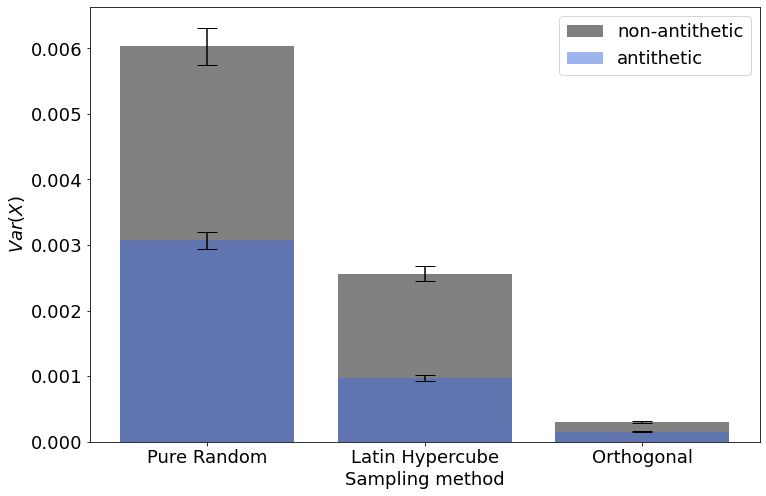

In [76]:
def draw_bar_antithetic(areas_normal,areas_anti,boot_ci_normal,boot_ci_anti,fname="Barchart_anti"):
    plt.figure(figsize=(12,8))
    anti_var = np.var(areas_anti,axis=0)
    norm_var = np.var(areas_normal,axis=0)
    labels = ["Pure Random", "Latin Hypercube", "Orthogonal"]
    plt.bar(labels,norm_var,color='grey',yerr=boot_ci_normal.standard_error,capsize=10,label="non-antithetic")
    plt.bar(labels,anti_var,color='royalblue',yerr=boot_ci_anti.standard_error,edgecolor="None",linewidth=2,alpha=0.5,label="antithetic",capsize=10)
    plt.xlabel("Sampling method")
    plt.ylabel(fr"$Var(X)$")
    plt.legend()
    plt.savefig('figures/'+fname+'.svg', bbox_inches="tight")

draw_bar_antithetic(areas_normal,areas_anti,boot_ci_normal,boot_ci_anti,fname="Barchart_anti")